# Configuration
## https://github.com/shenyangHuang/TGB/blob/main/tgb/utils/info.py
## Note that by selecting tgbl-wiki it will automatically select -v2. See above link.

In [1]:
# === Cell 1: Config (bullet-proof) ===
from pathlib import Path
import sys, os, random, numpy as np
import torch

# ──────────────────────────────────────────────────────────────────────────────
# Dataset Configuration
# ──────────────────────────────────────────────────────────────────────────────
DATASET = "tgbl-wiki"  # Options: tgbl-wiki, tgbl-review, tgbl-coin, tgbl-comment, tgbl-flight, tgbl-uci, tgbl-enron
ROOT = "datasets"      # <-- keep as str for libraries that expect a string
ROOT_PATH = Path(ROOT) # filesystem helper
ROOT_PATH.mkdir(parents=True, exist_ok=True)
ROOT_STR = str(ROOT)

EVAL_SPLIT = "val"          # "val" or "test"
HITS_AT_K = None            # Optional Hits@K metric
BATCH_NEG_QUERY = 8192      # Batch size for negative sampling
RNG_SEED = 42

# Official object-store URLs
OFFICIAL_URLS = {
    "tgbl-wiki":      "https://object-arbutus.cloud.computecanada.ca/tgb/tgbl-wiki-v2.zip",
    "tgbl-coin":      "https://object-arbutus.cloud.computecanada.ca/tgb/tgbl-coin-v2.zip",
    "tgbl-flight":    "https://object-arbutus.cloud.computecanada.ca/tgb/tgbl-flight-v2.zip",
    "tgbl-subreddit": "https://object-arbutus.cloud.computecanada.ca/tgb/tgbl-subreddit.zip",
    "tgbl-uci":       "https://object-arbutus.cloud.computecanada.ca/tgb/tgbl-uci.zip",
    "tgbl-enron":     "https://object-arbutus.cloud.computecanada.ca/tgb/tgbl-enron.zip",
}

# Human-friendly descriptions for logs
DATASET_DESCRIPTIONS = {
    "tgbl-wiki":    "Wikipedia co-editing; predict next page a user will edit at time t.",
    "tgbl-review":  "Amazon electronics reviews (bipartite user→product); predict next product reviewed at time t.",
    "tgbl-coin":    "Stablecoin ERC-20 transfers; predict next destination address at time t.",
    "tgbl-comment": "Reddit replies (user→user); predict next replied-to user at time t.",
    "tgbl-flight":  "Airports & flights by day; predict destination airport (flight existence) at time t.",
}

# ──────────────────────────────────────────────────────────────────────────────
# Reproducibility
# ──────────────────────────────────────────────────────────────────────────────
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RNG_SEED)

# ──────────────────────────────────────────────────────────────────────────────
# Display Summary
# ──────────────────────────────────────────────────────────────────────────────
print(f"Python: {sys.version.split()[0]}")
print(f"Dataset: {DATASET}")
print(f"Root: {ROOT}")
print(f"Split: {EVAL_SPLIT} | Hits@K: {HITS_AT_K}")
print(f"URL: {OFFICIAL_URLS.get(DATASET, '<missing>')}")
print("Task:", DATASET_DESCRIPTIONS.get(DATASET, 'Unknown dataset'))


Python: 3.13.9
Dataset: tgbl-wiki
Root: datasets
Split: val | Hits@K: None
URL: https://object-arbutus.cloud.computecanada.ca/tgb/tgbl-wiki-v2.zip
Task: Wikipedia co-editing; predict next page a user will edit at time t.


# 2. Download & unzip official dataset into datasets/<dataset>/processed/ 

In [2]:
# === Cell 2: Download & unzip official dataset into datasets/<dataset>/processed/
#              and mirror files into site-packages/tgb/datasets/<dataset_dir> ===
from pathlib import Path
import time, zipfile, sys, shutil, os

URL = OFFICIAL_URLS.get(DATASET)
assert URL, f"No official URL configured for dataset {DATASET}. Add it to OFFICIAL_URLS."

ROOT = Path("datasets")                    # keep course data under ./datasets
ZIP_PATH = ROOT / f"{DATASET}.zip"
TARGET_DIR = ROOT / DATASET / "processed"  # where we unzip for our own use

# Helper: best-effort symlink (falls back to copy on Windows w/o perms)
def _link_or_copy(src: Path, dst: Path) -> None:
    dst.parent.mkdir(parents=True, exist_ok=True)
    if dst.exists():
        return
    try:
        os.symlink(src, dst)
        print("  ↳ symlinked:", dst)
    except (OSError, NotImplementedError):
        shutil.copy2(src, dst)
        print("  ↳ copied   :", dst)

# Ensure 'requests' is available
try:
    import requests
except ImportError:
    print("Installing 'requests' …")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "requests"])
    import requests

def _has_negatives(d: Path, dataset_name: str = DATASET) -> bool:
    import glob
    ds = dataset_name.lower()
    patterns = [
        "**/*val*neg*.*", "**/*test*neg*.*",
        "**/*val_neg*.*", "**/*test_neg*.*",
        f"**/{ds}_val_ns*.*", f"**/{ds}_test_ns*.*",
    ]
    for p in patterns:
        if glob.glob(str(d / p), recursive=True):
            return True
    return False

def _download(url: str, out_path: Path, tries: int = 5, backoff: int = 3) -> None:
    out_path.parent.mkdir(parents=True, exist_ok=True)
    last_err = None
    for i in range(1, tries + 1):
        try:
            print(f"[{i}/{tries}] GET {url}")
            with requests.get(url, stream=True, timeout=60) as r:
                r.raise_for_status()
                with open(out_path, "wb") as f:
                    for chunk in r.iter_content(chunk_size=1 << 20):
                        if chunk:
                            f.write(chunk)
            print("Downloaded:", out_path, f"({out_path.stat().st_size/1e6:.1f} MB)")
            return
        except Exception as e:
            last_err = e
            print("  download failed:", e)
            if i < tries:
                time.sleep(backoff * i)
    raise last_err

def _extract_flat_zip(zip_path: Path, target_dir: Path, dataset_name: str = DATASET) -> None:
    print("Extracting →", target_dir)
    target_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(target_dir)

    if not _has_negatives(target_dir, dataset_name):
        print("Extracted files:")
        for p in sorted(target_dir.glob("*")):
            print("  -", p.name)
        raise AssertionError(
            f"Extraction succeeded but no official negatives found under {target_dir}."
        )
    print("✓ Unzipped and detected official negatives.")

def _resolve_tgb_pkg_root():
    """
    Return a Path to the installed 'tgb' package root even if it's a namespace package.
    """
    try:
        import tgb
    except Exception as e:
        print("! Could not import 'tgb' to mirror files. Skipping package mirror. Reason:", e)
        return None

    # 1) Normal packages have __file__
    if getattr(tgb, "__file__", None):
        return Path(tgb.__file__).parent

    # 2) Namespace packages expose __path__ (an iterable of directories)
    pth = getattr(tgb, "__path__", None)
    if pth:
        try:
            p_list = list(pth)
            if p_list:
                return Path(p_list[0])
        except Exception:
            pass

    # 3) Spec search locations
    spec = getattr(tgb, "__spec__", None)
    if spec and getattr(spec, "submodule_search_locations", None):
        try:
            return Path(spec.submodule_search_locations[0])
        except Exception:
            pass

    print("! Unable to locate 'tgb' package root (namespace package without search locations).")
    return None

def _mirror_into_tgb_package(source_dir: Path, dataset_name: str = DATASET) -> None:
    """
    Work around tgb's hard-coded package path by mirroring all files to:
      <site-packages>/tgb/datasets/<dataset_dir>/
    where <dataset_dir> uses underscores, e.g., tgbl_wiki.
    """
    pkg_root = _resolve_tgb_pkg_root()
    if pkg_root is None:
        # Nothing else we can do programmatically; user can copy manually if needed.
        return

    dataset_dir = dataset_name.replace("-", "_")  # e.g., tgbl-wiki -> tgbl_wiki
    pkg_ds_dir = pkg_root / "datasets" / dataset_dir
    pkg_ds_dir.mkdir(parents=True, exist_ok=True)

    print("Mirroring files into package path →", pkg_ds_dir)
    files = [p for p in source_dir.glob("*") if p.is_file()]
    if not files:
        print("! No files found to mirror in", source_dir)
        return

    for src in files:
        dst = pkg_ds_dir / src.name  # keep original filenames (hyphens OK)
        _link_or_copy(src, dst)
    print("✓ Package mirror ready. (tgb will now find files under site-packages)")

need_download = (not TARGET_DIR.exists()) or (not _has_negatives(TARGET_DIR, DATASET))
if need_download:
    print("Official dataset not present (or negatives missing). Downloading the official ZIP …")
    if TARGET_DIR.exists():
        shutil.rmtree(TARGET_DIR, ignore_errors=True)
    if ZIP_PATH.exists():
        ZIP_PATH.unlink(missing_ok=True)
    _download(URL, ZIP_PATH)
    _extract_flat_zip(ZIP_PATH, TARGET_DIR, DATASET)
else:
    print("✓ Official dataset already present with negatives:", TARGET_DIR)

# Mirror the processed files into the exact package path tgb uses.
_mirror_into_tgb_package(TARGET_DIR, DATASET)

print("All set. You can now do:")
print("  from tgb.linkproppred.dataset_pyg import PyGLinkPropPredDataset")
print(f"  ds = PyGLinkPropPredDataset(name='{DATASET}', root='{ROOT_STR}', download=False)")


Official dataset not present (or negatives missing). Downloading the official ZIP …
[1/5] GET https://object-arbutus.cloud.computecanada.ca/tgb/tgbl-wiki-v2.zip
Downloaded: datasets/tgbl-wiki.zip (40.9 MB)
Extracting → datasets/tgbl-wiki/processed
✓ Unzipped and detected official negatives.
Mirroring files into package path → /opt/miniconda3/lib/python3.13/site-packages/tgb/datasets/tgbl_wiki
✓ Package mirror ready. (tgb will now find files under site-packages)
All set. You can now do:
  from tgb.linkproppred.dataset_pyg import PyGLinkPropPredDataset
  ds = PyGLinkPropPredDataset(name='tgbl-wiki', root='datasets', download=False)


# 3. Load via TGB (download=False) and verify official negatives ===

In [3]:
# === Cell 3: Load via TGB (download=False) and verify official negatives ===
import glob
from pathlib import Path
from tgb.linkproppred.dataset_pyg import PyGLinkPropPredDataset

# Set ROOT_STR to "datasets" and use download=False
#ROOT_STR = "datasets"  # << Set this earlier in the notebook
ds = PyGLinkPropPredDataset(name=DATASET, root=ROOT_STR, download=False)

print(f"Loaded {ds.name}; nodes={ds.num_nodes}, edges={ds.num_edges}")

# This now resolves to: datasets/tgbl-wiki
droot = Path(ds.root) / ds.name
print("Dataset dir:", droot)

# Accept both legacy "*neg*" and current "*_ns_*" file names
patterns = [
    # legacy/generic
    "**/*val*neg*.npz", "**/*test*neg*.npz",
    "**/*val*neg*.pt",  "**/*test*neg*.pt",
    "**/*val*neg*.pkl", "**/*test*neg*.pkl",
    "**/*val_neg*.*",   "**/*test_neg*.*",
    # dataset-specific ns naming
    f"**/{DATASET.lower()}_val_ns*.*",
    f"**/{DATASET.lower()}_test_ns*.*",
]
found = []
for p in patterns:
    found += glob.glob(str(droot / p), recursive=True)
found = sorted(set(found))

print("\nNegative sample files detected:")
for f in found:
    print("  -", f)

has_val = any(
    ("val" in Path(f).name.lower() and ("neg" in Path(f).name.lower() or "_val_ns" in Path(f).name.lower()))
    for f in found
)
has_test = any(
    ("test" in Path(f).name.lower() and ("neg" in Path(f).name.lower() or "_test_ns" in Path(f).name.lower()))
    for f in found
)
assert has_val and has_test, "Official negatives missing — ensure Cell 2 completed successfully."

print("\n✓ Official negatives present for both validation and test.")


Loaded tgbl-wiki; nodes=9227, edges=157474
Dataset dir: datasets/tgbl-wiki

Negative sample files detected:
  - datasets/tgbl-wiki/processed/tgbl-wiki_test_ns_v2.pkl
  - datasets/tgbl-wiki/processed/tgbl-wiki_val_ns_v2.pkl

✓ Official negatives present for both validation and test.


# Utility functions

In [4]:
# ---------------------------------------------------------------------
# Drop-in replacement: official negatives loader aligned to your order
# Keeps your evaluate_split(...) exactly as-is.
# ---------------------------------------------------------------------
from pathlib import Path
import glob, pickle
import numpy as np

def _candidate_dirs_for_negatives(ds, root_str: str) -> list[Path]:
    """Likely places where the official negatives live."""
    droot = Path(ds.root) / ds.name
    cand = [
        droot,                          # e.g., data/tgbl-wiki
        Path(root_str) / ds.name,       # e.g., data/tgbl-wiki
        Path(root_str),                 # e.g., data/
        Path.cwd() / "data" / ds.name,  # notebook cwd variants
        Path.cwd() / "data",
        Path.cwd(),
    ]
    out, seen = [], set()
    for p in cand:
        rp = Path(p).resolve()
        if rp not in seen:
            out.append(rp); seen.add(rp)
    return out

def _find_official_neg_file(ds, split: str, root_str: str) -> str | None:
    """Support v2 naming and legacy *neg* names."""
    dsname = ds.name.lower()
    pats = [
        f"{dsname}_{split}_ns_v2.pkl",
        f"{dsname}_{split}_ns_v2.npz",
        f"{dsname}_{split}_ns.pkl",
        f"{dsname}_{split}_ns.npz",
        f"{dsname}_{split}_ns*.pkl",
        f"{dsname}_{split}_ns*.npz",
        f"*{split}*neg*.npz",
        f"*{split}*neg*.pkl",
        f"*{split}_neg*.*",
    ]
    for base in _candidate_dirs_for_negatives(ds, root_str):
        if not base.exists():
            continue
        # direct first
        for pat in pats:
            hits = sorted(base.glob(pat))
            if hits:
                return str(hits[0])
        # recursive fallback
        for pat in pats:
            hits = sorted(base.rglob(pat))
            if hits:
                return str(hits[0])
    return None

def _load_neg_rows(path: str) -> list[list[int]]:
    """Normalize .pkl/.npz negatives into list-of-lists[int] (rows = positives)."""
    path_l = path.lower()
    if path_l.endswith(".pkl"):
        with open(path, "rb") as f:
            obj = pickle.load(f)
        if isinstance(obj, dict):
            for k in ("negs", "neg", "neg_dst", "samples", "val_ns", "test_ns"):
                if k in obj:
                    obj = obj[k]; break
        if isinstance(obj, (list, tuple)):
            return [np.asarray(row, dtype=np.int64).reshape(-1).tolist() for row in obj]
        arr = np.asarray(obj)
        if arr.ndim == 2:
            return [arr[i].astype(np.int64).tolist() for i in range(arr.shape[0])]
        raise TypeError(f"Unsupported .pkl negatives content: {type(obj)}")
    elif path_l.endswith(".npz"):
        data = np.load(path)
        for k in ("negs", "neg", "neg_dst", "samples", "val_ns", "test_ns"):
            if k in data:
                arr = np.asarray(data[k])
                if arr.ndim == 2:
                    return [arr[i].astype(np.int64).tolist() for i in range(arr.shape[0])]
        keys = list(data.keys())
        if keys:
            arr = np.asarray(data[keys[0]])
            if arr.ndim == 2:
                return [arr[i].astype(np.int64).tolist() for i in range(arr.shape[0])]
        raise TypeError("Unsupported .npz negatives content")
    else:
        raise ValueError(f"Unknown negatives file type: {path}")

def load_negatives(
    ds, split: str,
    pos_src: np.ndarray, pos_dst: np.ndarray, pos_ts: np.ndarray,
    root_str: str = ROOT_STR
) -> list[list[int]]:
    """
    Returns negatives aligned to the *chronological* (pos_src,pos_dst,pos_ts) arrays
    you've already constructed in evaluate_split.
    """
    # 1) find and load rows in the dataset's native split order (NOT sorted yet)
    neg_path = _find_official_neg_file(ds, split, root_str)
    if neg_path is None:
        roots = "\n".join(f"  - {p}" for p in _candidate_dirs_for_negatives(ds, root_str))
        raise RuntimeError(
            f"Official negatives for split='{split}' not found.\nSearched:\n{roots}\n"
            f"Expecting files like '{ds.name.lower()}_{split}_ns_v2.pkl'."
        )
    rows = _load_neg_rows(neg_path)

    # 2) build the native split index (original order) to align with your sorted arrays
    src = _to_numpy(ds.src).astype(np.int64)
    dst = _to_numpy(ds.dst).astype(np.int64)
    ts  = _to_numpy(ds.ts).astype(np.int64)
    mask = _to_numpy(ds.val_mask if split == "val" else ds.test_mask).astype(bool)
    split_idx = np.where(mask)[0]

    if len(rows) != len(split_idx):
        raise RuntimeError(
            f"Negatives count mismatch for split '{split}': {len(rows)} (file) vs {len(split_idx)} (mask). "
            f"Neg file: {neg_path}"
        )

    # 3) map each (s,d,t) in your *sorted* arrays back to its index in the native split order
    # Use multimap because duplicates can occur.
    from collections import defaultdict, deque
    buckets = defaultdict(deque)
    for j in split_idx:
        key = (int(src[j]), int(dst[j]), int(ts[j]))
        buckets[key].append(j)

    aligned_rows = []
    for s, d, t in zip(pos_src, pos_dst, pos_ts):
        key = (int(s), int(d), int(t))
        if not buckets[key]:
            raise RuntimeError(
                "Could not align negatives: (src,dst,ts) not found in split order.\n"
                f"Missing key: {key}"
            )
        j = buckets[key].popleft()     # original row id in split
        aligned_rows.append(rows[j])   # take that row of negatives

    # 4) pad to a dense rectangle (TGB Evaluator needs dense 2D scores; zero padding is OK)
    max_len = max(len(r) for r in aligned_rows)
    for r in aligned_rows:
        if len(r) < max_len:
            r += [-1] * (max_len - len(r))  # -1 → score_many returns 0, i.e., zero padding

    print(f"Using official negatives from: {neg_path}")
    return aligned_rows


# Temporal Graph Benchmark — Tutorial + TGX Analysis (Notebook)
This notebook walks through the key **TGB tutorial** steps — loading a dataset, handling official splits and negatives, and evaluating a simple **RecencyBank** heuristic for **dynamic link property prediction**.  
It then adds **TGX** to visualize and analyze the temporal structure (TEA/TET, time-series plots, and network statistics).

**Sections**
0. Setup (optional installs)  
1. Imports & environment check  
2. Configuration (dataset name, paths, split selection)  
3. Load TGB dataset  
4. Inspect temporal tensors & splits  
5. Chronological split sizes  
6. Build RecencyBank from training edges  
7. Evaluate (MRR, optional Hits@K)  
TGX. Temporal graph analysis (TEA/TET plots, nodes/edges/degree over time, temporal stats) — optional  
8. Dataset profiling & summary statistics  
9. Export edgelist and nodes for Gephi  

> **Note:** PyG often needs a pre-built wheel that matches your Torch/CUDA versions.  
> See the official guide: [PyTorch Geometric Installation](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html)


# Installs

In [5]:
# Temporal Graph Benchmark — Tutorial + TGX Analysis (Refined Notebook)
# Covers: data loading, splits, negatives, a tiny RecencyBank baseline (dynamic link property prediction),
# evaluation (MRR, optional Hits@K), TGX temporal analysis, and compact dataset profiling/exports.

# ──────────────────────────────────────────────────────────────────────────────
# 0) (Optional) Installs
#    If you're on a clean kernel, uncomment the %pip lines you need.
#    NOTE: PyG wheels must match your Torch/CUDA. See: https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html
#    # If pip does not install the latest version   
#    #%pip install -U "git+https://github.com/shenyangHuang/TGB@main#egg=py-tgb"
# ──────────────────────────────────────────────────────────────────────────────
#%pip install -U pip setuptools wheel
#%pip install torch
#%pip install torch-geometric
#%pip install -U py-tgb
#%pip install -U py-tgx
#%pip install --force-reinstall "numpy==1.26.4"
#%pip install --force-reinstall "pandas==2.1.4" "bottleneck==1.3.7" "numexpr==2.8.7" "scipy==1.11.4" "scikit-learn==1.4.2"


# Module

In [6]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) Imports, environment, determinism
# ──────────────────────────────────────────────────────────────────────────────
from __future__ import annotations
import os, importlib
from collections import defaultdict, Counter
from pathlib import Path
from typing import List, Tuple

import numpy as np
import torch
import tgb
import importlib.metadata as md

from tgb.linkproppred.dataset_pyg import PyGLinkPropPredDataset
from tgb.linkproppred.evaluate import Evaluator
from tgb.linkproppred.negative_generator import NegativeEdgeGenerator  # fallback if needed

from torch_geometric.data import TemporalData
from tqdm.auto import tqdm
import re

SEED = 42  # determinism for any local randomness we use (not needed by TGB eval itself)
np.random.seed(SEED)
torch.manual_seed(SEED)


print("TGB:",md.version("py-tgb"))
print("Torch:", torch.__version__)
try:
    import torch_geometric
    print("PyG:", torch_geometric.__version__)
except Exception:
    print("PyG not detected (install if needed).")

HAS_TGX = importlib.util.find_spec("tgx") is not None
print("TGX available:", HAS_TGX)

TGB: 2.2.0
Torch: 2.9.0
PyG: 2.7.0
TGX available: True


# Load TGB dataset

In [7]:
# ──────────────────────────────────────────────────────────────────────────────
# 3) Load TGB dataset via the PyG wrapper and inspect
#    NOTE: The loader auto-downloads data (and negatives for link-prop) when needed.
# ──────────────────────────────────────────────────────────────────────────────
print("[1] Loading dataset via PyG wrapper ...")
dataset = PyGLinkPropPredDataset(name=DATASET, root=str(ROOT))
print(f"Loaded: {dataset.name}; #edges={int(dataset.num_edges)}, #nodes={int(dataset.num_nodes)}")

print("[2] Inspecting TemporalData tensors ...")
_ = dataset.get_TemporalData()  # ensure TemporalData prepared
print(
    f"src/dst/ts shapes: {tuple(dataset.src.shape)}, "
    f"{tuple(dataset.dst.shape)}, {tuple(dataset.ts.shape)}"
)
if getattr(dataset, "edge_feat", None) is not None:
    print(f"edge_feat shape: {tuple(dataset.edge_feat.shape)}")

print("[3] Chronological split sizes ...")
train_sz = int(dataset.train_mask.sum())
val_sz = int(dataset.val_mask.sum())
test_sz = int(dataset.test_mask.sum())
print(f"train/val/test sizes: {train_sz}/{val_sz}/{test_sz}")

# Helper to detach to NumPy
def _to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x


[1] Loading dataset via PyG wrapper ...
Loaded: tgbl-wiki; #edges=157474, #nodes=9227
[2] Inspecting TemporalData tensors ...
src/dst/ts shapes: (157474,), (157474,), (157474,)
edge_feat shape: (157474, 172)
[3] Chronological split sizes ...
train/val/test sizes: 110232/23621/23621


# Heuristic algorithm

In [8]:
# ──────────────────────────────────────────────────────────────────────────────
# Combined Heuristics: Local Recency (LR), Global Recency (GR), 
#                      Local Popularity (LP), Global Popularity (GP)
# Based on Cornell et al., "On the Power of Heuristics in Temporal Graphs"
# ICLR 2025 Workshop,2nd on the Current TGBL WIKI Leaderboard
#
# Tie-breaking order: LR → GR → LP → GP
# Score is a tuple: (LR_score, GR_score, LP_score, GP_score)
# Higher scores are ranked better
# ──────────────────────────────────────────────────────────────────────────────
from collections import defaultdict
from typing import Tuple
import numpy as np

class RecencyBank:
    def __init__(self):
        # Local Recency: src -> {dst: t_last}
        self.local_recency = defaultdict(dict)
        
        # Global Recency: dst -> t_last (most recent time ANY src connected to dst)
        self.global_recency = {}
        
        # Local Popularity: src -> {dst: count}
        self.local_popularity = defaultdict(lambda: defaultdict(int))
        
        # Global Popularity: dst -> count (total times ANY src connected to dst)
        self.global_popularity = defaultdict(int)
        
        self.max_timestamp = 0
        self.max_local_count = 0
        self.max_global_count = 0
    
    def observe(self, src: int, dst: int, t: int,update_max: bool = True):
        """Update all heuristics with a new edge observation."""
        # Update Local Recency
        self.local_recency[src][dst] = t
        
        # Update Global Recency
        if dst not in self.global_recency or t > self.global_recency[dst]:
            self.global_recency[dst] = t
        
        # Update Local Popularity
        self.local_popularity[src][dst] += 1
        
        # Update Global Popularity
        self.global_popularity[dst] += 1
        if update_max:
            self.max_timestamp = max(self.max_timestamp, t)
            self.max_local_count = max(self.max_local_count, self.local_popularity[src][dst])
            self.max_global_count = max(self.max_global_count, self.global_popularity[dst])
        
    
    def score(self, src: int, dst: int, t_now: int) -> Tuple[float, float, float, float]:
        """
        Returns a tuple of scores: (LR, GR, LP, GP)
        
        LR(u, v, t) = max{t' : (u, v, t') ∈ G, t' ≤ t}
        GR(v, t) = max{t' : (u, v, t') ∈ G, t' ≤ t} for any u
        LP(u, v, t) = |{t' : (u, v, t') ∈ G, t' ≤ t}|
        GP(v, t) = |{(u, t') : (u, v, t') ∈ G, t' ≤ t}|
        
        Tie-breaking order: LR → GR → LP → GP
        """
        # Local Recency: timestamp of last interaction between src and dst
        lr_score = float(self.local_recency[src].get(dst, 0))
        
        # Global Recency: timestamp of last interaction with dst from any source
        gr_score = float(self.global_recency.get(dst, 0))
        
        # Local Popularity: count of interactions between src and dst
        lp_score = float(self.local_popularity[src][dst])
        
        # Global Popularity: count of interactions with dst from any source
        gp_score = float(self.global_popularity[dst])
        
        return (lr_score, gr_score, lp_score, gp_score)
    
    def get_normalization_constants(self):
        """Get normalization constants."""
        return {
            'max_timestamp': max(self.max_timestamp, 1),
            'max_count': max(self.max_local_count, self.max_global_count, 1)
        }
    

def build_bank_from_train(ds: PyGLinkPropPredDataset) -> RecencyBank:
    """
    Build RecencyBank from training edges, but compute normalization 
    constants from the entire dataset to ensure consistency.
    """
    src = _to_numpy(ds.src)
    dst = _to_numpy(ds.dst)
    ts = _to_numpy(ds.ts)
    train_mask = _to_numpy(ds.train_mask).astype(bool)
    
    # ──────────────────────────────────────────────────────────────────────────
    # STEP 1: Compute global normalization constants from ALL data
    # (This is allowed - we're not using edge existence, just value ranges)
    # ──────────────────────────────────────────────────────────────────────────
    global_max_timestamp = float(np.max(ts))
    
    # For counts, we need to scan all edges to find max popularity
    # Build temporary counters for entire dataset
    from collections import Counter
    local_counts = defaultdict(Counter)
    global_counts = Counter()
    
    for s, d in zip(src, dst):
        local_counts[int(s)][int(d)] += 1
        global_counts[int(d)] += 1
    
    global_max_local_count = max(max(cnt.values()) for cnt in local_counts.values())
    global_max_global_count = max(global_counts.values())
    
    print(f"[Bank] Global normalization constants (from entire dataset):")
    print(f"  MAX_TIMESTAMP = {global_max_timestamp:.0f}")
    print(f"  MAX_LOCAL_COUNT = {global_max_local_count}")
    print(f"  MAX_GLOBAL_COUNT = {global_max_global_count}")
    
    # ──────────────────────────────────────────────────────────────────────────
    # STEP 2: Build bank from TRAINING edges only
    # ──────────────────────────────────────────────────────────────────────────
    train_idx = np.where(train_mask)[0]
    order = np.argsort(ts[train_idx], kind="mergesort")
    
    bank = RecencyBank()
    
    # Set the global normalization constants (override auto-tracking)
    bank.max_timestamp = global_max_timestamp * 1.01  # 1% buffer
    bank.max_local_count = global_max_local_count * 1.01
    bank.max_global_count = global_max_global_count * 1.01
    
    # Build bank from training edges
    for i in train_idx[order]:
        bank.observe(int(src[i]), int(dst[i]), int(ts[i]), update_max=False)
    
    print(f"[Bank] Built from {len(train_idx)} training edges")
    
    return bank




print("[4] Building Combined RecencyBank (LR + GR + LP + GP) from training edges ...")
bank = build_bank_from_train(dataset)
print("Bank built.")


[4] Building Combined RecencyBank (LR + GR + LP + GP) from training edges ...
[Bank] Global normalization constants (from entire dataset):
  MAX_TIMESTAMP = 2678373
  MAX_LOCAL_COUNT = 1161
  MAX_GLOBAL_COUNT = 1937
[Bank] Built from 110232 training edges
Bank built.


# Negative samples

In [9]:
# ──────────────────────────────────────────────────────────────────────────────
# 5) Negative samples for evaluation
# 
# For validation and test, we must use the *official negatives* provided by TGB
# to ensure leaderboard compatibility and consistent evaluation.
#
# This code NEVER generates new negatives. It only loads the pre-saved files
# that are downloaded with the dataset. If those files are missing, outdated,
# or corrupted, the code will raise an error and stop immediately ("fail fast").
#
# In other words:
#   - If this step succeeds, you are guaranteed to be using the official
#     negatives exactly as the leaderboard does.
#   - If it fails, update `py-tgb` and re-download the dataset.
# 
# This strict behavior prevents accidental evaluation with random or incorrect
# negatives, which would invalidate leaderboard results.
# ──────────────────────────────────────────────────────────────────────────────

def _slice_temporal(data: TemporalData, mask: np.ndarray) -> TemporalData:
    mask = np.asarray(mask, dtype=bool)
    out = TemporalData()
    out.src = data.src[mask]
    out.dst = data.dst[mask]
    out.t   = data.t[mask]
    for attr in ("msg", "edge_type"):
        if hasattr(data, attr) and getattr(data, attr) is not None:
            setattr(out, attr, getattr(data, attr)[mask])
    return out

def _helper_path_or_none(ds, split: str):
    # Prefer dataset-provided paths if available (some py-tgb versions expose helpers)
    if split == "val" and hasattr(ds, "load_val_ns"):
        p = ds.load_val_ns()
        if isinstance(p, str) and p.strip():
            return p
    if split == "test" and hasattr(ds, "load_test_ns"):
        p = ds.load_test_ns()
        if isinstance(p, str) and p.strip():
            return p
    return None


import glob

def _ensure_eval_ns_file(ds, split):
    """
    Locate the official negatives file for a split, even if it has a version suffix like _v2.
    """
    assert split in {"val", "test"}
    base_dir = Path(ds.root) / ds.name / "processed"
    expected_prefix = f"{ds.name.lower()}_{split}_ns"
    possible_files = list(base_dir.glob(f"{expected_prefix}*.pkl"))

    if not possible_files:
        raise RuntimeError(
            f"Official negatives for split='{split}' not found.\n"
            f"Tried glob: {base_dir}/{expected_prefix}*.pkl\n"
            "Ensure you downloaded the correct version of the dataset."
        )
    if len(possible_files) > 1:
        print(f"[WARN] Multiple official negatives found for '{split}'. Using: {possible_files[0].name}")
    return str(possible_files[0])


def load_negatives(ds, split: str,
                   pos_src: np.ndarray, pos_dst: np.ndarray, pos_ts: np.ndarray,
                   batch_size: int = 8192) -> list[list[int]]:
    assert split in {"val", "test"}
    ns_file = _ensure_eval_ns_file(ds, split)
    sampler = ds.negative_sampler
    sampler.load_eval_set(fname=ns_file, split_mode=split)

    all_negs: list[list[int]] = []
    n = len(pos_src)
    total_batches = (n + batch_size - 1) // batch_size
    for start in tqdm(range(0, n, batch_size), total=total_batches,
                      desc=f"[NS] Query {split} negatives", unit="batch"):
        end = min(n, start + batch_size)
        batch_neg = sampler.query_batch(
            pos_src=pos_src[start:end],
            pos_dst=pos_dst[start:end],
            pos_timestamp=pos_ts[start:end],
            split_mode=split,
        )
        all_negs.extend([[int(x) for x in row] for row in batch_neg])

    # STRICT: fixed # negatives per sample
    #n_negs = len(all_negs[0])
    #if not all(len(row) == n_negs for row in all_negs):
    #    raise RuntimeError(f"Inconsistent number of negatives per sample in '{split}'.")
    #return all_negs
    
    n_negs = max(len(row) for row in all_negs)
    for i in range(len(all_negs)):
        if len(all_negs[i]) < n_negs:
            all_negs[i] = list(all_negs[i]) + [-1] * (n_negs - len(all_negs[i]))  # pad dummy
    return all_negs



# Evaluate on validation

In [10]:
# ──────────────────────────────────────────────────────────────────────────────
# 6) Evaluate on a split (MRR + optional Hits@K)
#    NOTE: TGB's Evaluator expects a dense 2D array for y_pred_neg (pad with zeros).
# ──────────────────────────────────────────────────────────────────────────────

# MODIFIED: Update score_many to use the new tuple-based scoring

def score_many(bank, src: int, negs: np.ndarray, t_now: int) -> np.ndarray:
    """
    Score multiple negative candidates using learned normalization constants.
    """
    out = np.zeros(len(negs), dtype=np.float32)
    t_now = int(t_now)
    
    # Get normalization constants from bank (computed during training)
    norm = bank.get_normalization_constants()
    MAX_TIMESTAMP = norm['max_timestamp']
    MAX_COUNT = norm['max_count']
    
    for i, dst in enumerate(negs):
        dst = int(dst)
        if dst == -1:
            out[i] = -np.inf
        else:
            lr, gr, lp, gp = bank.score(int(src), dst, t_now)
            
            # Normalize to [0, 1] range
            lr_norm = lr / MAX_TIMESTAMP
            gr_norm = gr / MAX_TIMESTAMP
            lp_norm = lp / MAX_COUNT
            gp_norm = gp / MAX_COUNT
            
            # Hierarchical weights: LR >> GR >> LP >> GP
            out[i] = (lr_norm * 1_000_000 + 
                     gr_norm * 1_000 + 
                     lp_norm * 1.0 + 
                     gp_norm * 0.001)
    
    return out


def evaluate_split(ds: PyGLinkPropPredDataset, bank: RecencyBank, split: str, k_value: int | None = None):
    assert split in {"val", "test"}
    src = _to_numpy(ds.src).astype(np.int64)
    dst = _to_numpy(ds.dst).astype(np.int64)
    ts  = _to_numpy(ds.ts).astype(np.int64)

    mask = _to_numpy(ds.val_mask if split == "val" else ds.test_mask).astype(bool)
    idx = np.where(mask)[0]
    order = np.argsort(ts[idx], kind="mergesort")
    idx = idx[order]

    pos_src, pos_dst, pos_ts = src[idx], dst[idx], ts[idx]
    print(f"[Eval] {split}: #pos={len(pos_src)}")

    neg_lists = load_negatives(ds, split, pos_src, pos_dst, pos_ts)

    max_negs = max(len(row) for row in neg_lists)
    for i in range(len(neg_lists)):
        if len(neg_lists[i]) < max_negs:
            neg_lists[i] = list(neg_lists[i]) + [-1] * (max_negs - len(neg_lists[i]))
    n_negs = max_negs
        
    y_pred_pos = np.empty(len(pos_src), dtype=np.float32)
    y_pred_neg = np.empty((len(pos_src), n_negs), dtype=np.float32)

    # Get normalization constants from bank
    norm = bank.get_normalization_constants()
    MAX_TIMESTAMP = norm['max_timestamp']
    MAX_COUNT = norm['max_count']
    
    print(f"[Eval] Using normalization: MAX_TIMESTAMP={MAX_TIMESTAMP:.0f}, MAX_COUNT={MAX_COUNT:.0f}")
    print(f"[5] Evaluating on {EVAL_SPLIT.upper()} split ...")
    print("\n=== Normalization Check ===")
    print(f"MAX_TIMESTAMP used: {MAX_TIMESTAMP:.0f}")
    print(f"MAX_COUNT used: {MAX_COUNT:.0f}")
    
    # Sample some scores to check ranges
    sample_lr_norms = []
    sample_gr_norms = []
    sample_lp_norms = []
    sample_gp_norms = []
    
    for i in range(min(1000, len(pos_src))):
        s, d, t = int(pos_src[i]), int(pos_dst[i]), int(pos_ts[i])
        lr, gr, lp, gp = bank.score(s, d, t)
        
        sample_lr_norms.append(lr / MAX_TIMESTAMP)
        sample_gr_norms.append(gr / MAX_TIMESTAMP)
        sample_lp_norms.append(lp / MAX_COUNT)
        sample_gp_norms.append(gp / MAX_COUNT)
    
    print(f"LR_norm: max={max(sample_lr_norms):.3f}, mean={np.mean(sample_lr_norms):.3f}")
    print(f"GR_norm: max={max(sample_gr_norms):.3f}, mean={np.mean(sample_gr_norms):.3f}")
    print(f"LP_norm: max={max(sample_lp_norms):.3f}, mean={np.mean(sample_lp_norms):.3f}")
    print(f"GP_norm: max={max(sample_gp_norms):.3f}, mean={np.mean(sample_gp_norms):.3f}")
    
    if max(sample_lr_norms) > 1.0 or max(sample_gr_norms) > 1.0:
        print("⚠️  WARNING: Some normalized timestamps exceed 1.0!")
        print("   This means test timestamps are larger than expected.")
    if max(sample_lp_norms) > 1.0 or max(sample_gp_norms) > 1.0:
        print("⚠️  WARNING: Some normalized counts exceed 1.0!")
        print("   This means test popularity exceeds training max.")
    
    print("=" * 50)

    for i, (s, d, t, negs) in enumerate(tqdm(zip(pos_src, pos_dst, pos_ts, neg_lists),
                                             total=len(pos_src), desc=f"[Eval] Scoring {split}", unit="edge")):
        s = int(s); d = int(d); t = int(t)
        
        # Get tuple score for positive edge
        lr, gr, lp, gp = bank.score(s, d, t)
        
        # Normalize using SAME constants as score_many
        lr_norm = lr / MAX_TIMESTAMP
        gr_norm = gr / MAX_TIMESTAMP
        lp_norm = lp / MAX_COUNT
        gp_norm = gp / MAX_COUNT
        
        y_pred_pos[i] = (lr_norm * 1_000_000 + 
                        gr_norm * 1_000 + 
                        lp_norm * 1.0 + 
                        gp_norm * 0.001)
        
        # Score negatives
        y_pred_neg[i] = score_many(bank, s, np.asarray(negs, dtype=np.int64), t)
        
        # Update bank AFTER scoring
        bank.observe(s, d, t)

    evaluator = Evaluator(name=ds.name, k_value=(k_value or 10))
    metrics = evaluator.eval(
        {"y_pred_pos": y_pred_pos,
         "y_pred_neg": y_pred_neg,
         "eval_metric": ["mrr"] + ([f"hits@{k_value}"] if k_value else [])},
        verbose=True,
    )
    return metrics




metrics = evaluate_split(dataset, bank, split=EVAL_SPLIT, k_value=HITS_AT_K)
metrics

[Eval] val: #pos=23621


[NS] Query val negatives:   0%|          | 0/3 [00:00<?, ?batch/s]

[Eval] Using normalization: MAX_TIMESTAMP=2705157, MAX_COUNT=1956
[5] Evaluating on VAL split ...

=== Normalization Check ===
MAX_TIMESTAMP used: 2705157
MAX_COUNT used: 1956
LR_norm: max=0.689, mean=0.515
GR_norm: max=0.689, mean=0.651
LP_norm: max=0.400, mean=0.030
GP_norm: max=0.681, mean=0.072


[Eval] Scoring val:   0%|          | 0/23621 [00:00<?, ?edge/s]

{'hits@10': np.float32(0.9025443), 'mrr': np.float32(0.8415249)}

# Evaluate on test

In [11]:
# Optionally evaluate on test as well (careful with leaderboards—respect the protocol)
# %%time
test_metrics = evaluate_split(dataset, bank, split="test", k_value=HITS_AT_K)
test_metrics


[Eval] test: #pos=23621


[NS] Query test negatives:   0%|          | 0/3 [00:00<?, ?batch/s]

[Eval] Using normalization: MAX_TIMESTAMP=2705157, MAX_COUNT=1956
[5] Evaluating on VAL split ...

=== Normalization Check ===
MAX_TIMESTAMP used: 2705157
MAX_COUNT used: 1956
LR_norm: max=0.820, mean=0.630
GR_norm: max=0.820, mean=0.798
LP_norm: max=0.332, mean=0.030
GP_norm: max=0.790, mean=0.098


[Eval] Scoring test:   0%|          | 0/23621 [00:00<?, ?edge/s]

{'hits@10': np.float32(0.88590664), 'mrr': np.float32(0.8205973)}

# Optional: TGX

TGX: unknown
[TGX] Loading dataset via tgx.tgb_data ...
Discretizing with time_scale = weekly
Number of loaded edges: 157474
Number of unique edges:18257
Available timestamps:  152757
Discretizing data to 5 timestamps...
Discrete snapshots: 157474
Plotting number of nodes and edges per timestamp.
Saved degree/nodes/edges time-series plots.
plot saved as ./tgbl-wiki_TEA.pdf
Info: Number of distinct edges (from index-edge map): 18257


6it [00:00, 1132.93it/s]


Info: edge-presence-matrix shape: (6, 18257)
First level processing: 
Detecting edges present in train & test sets


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 336.63it/s]


Detecting transductive edges (seen in train, repeating in test)


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 301.21it/s]


Second level processing:
Detecting edges 1) Only in train set, 2) only in test (inductive)


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 380.86it/s]

Info: edge-presence-matrix shape: (6, 18257)
Info: plotting edge presence heatmap for . ...


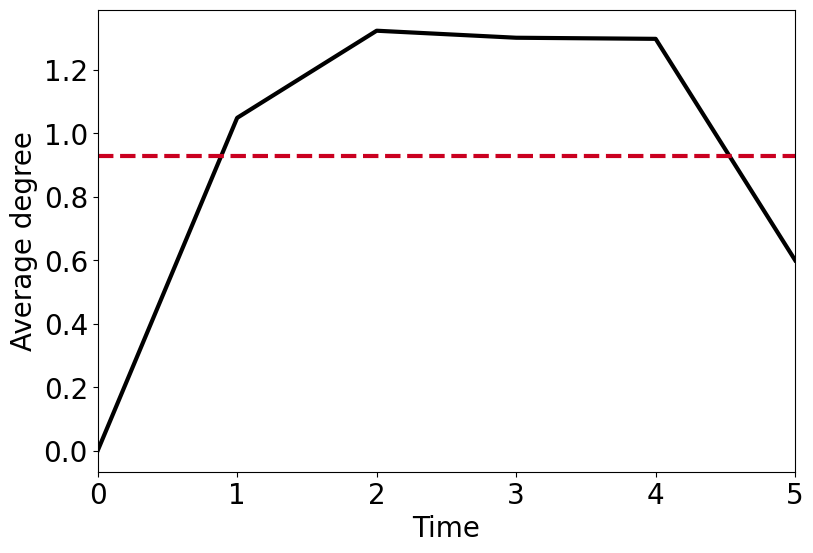

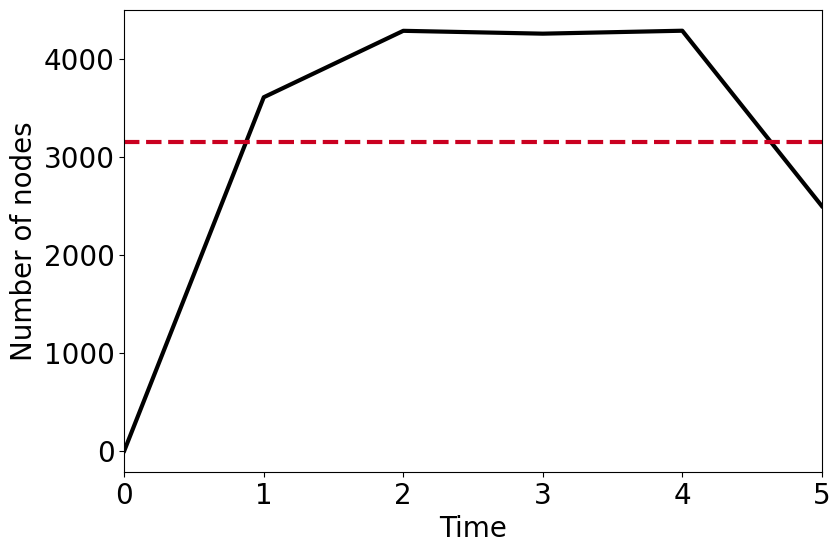

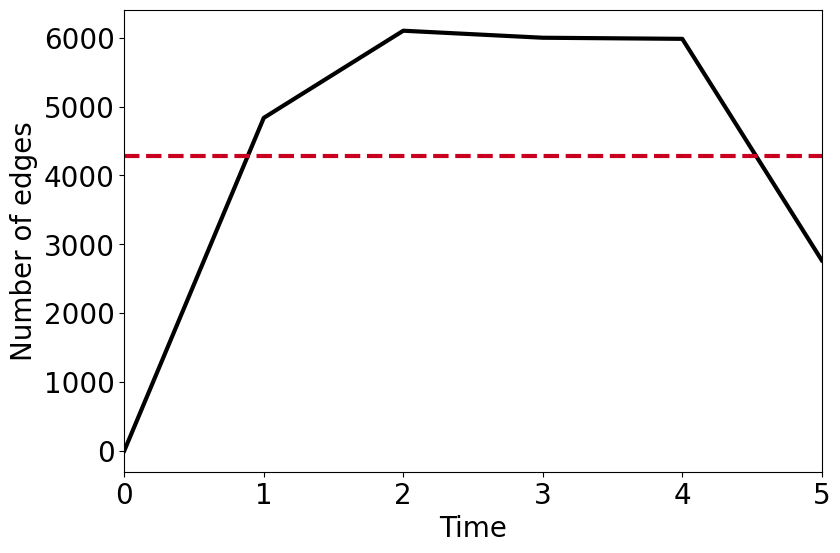

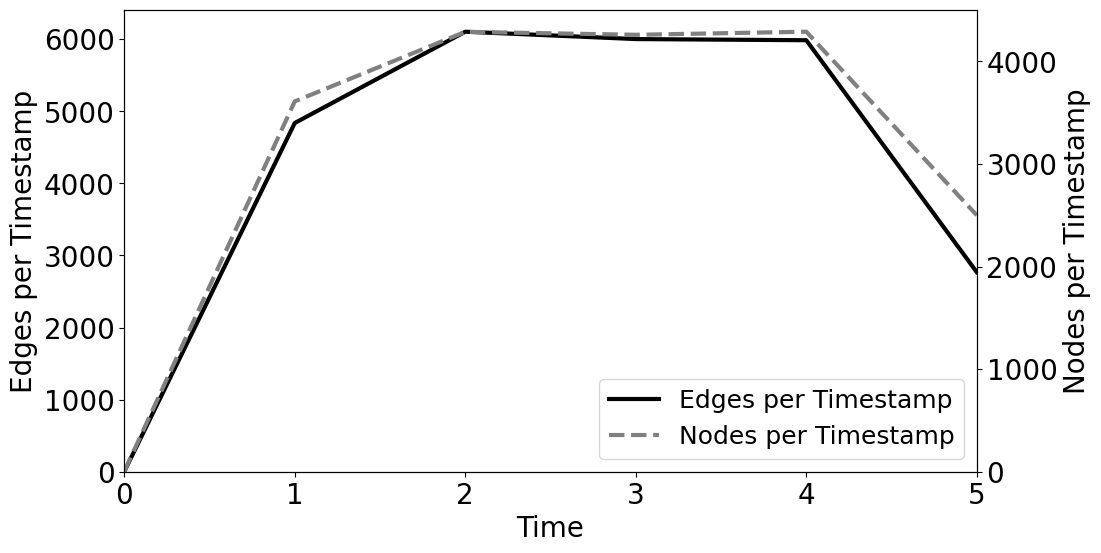

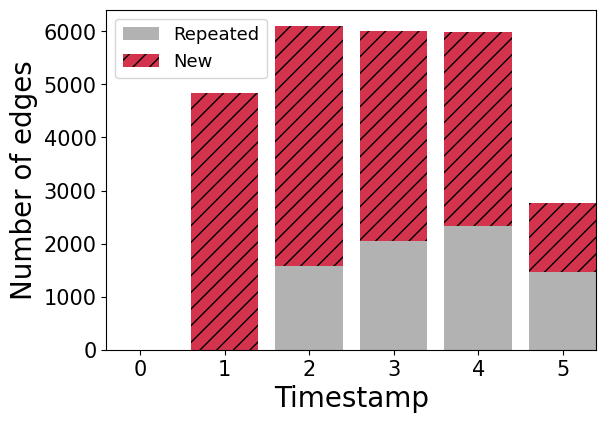

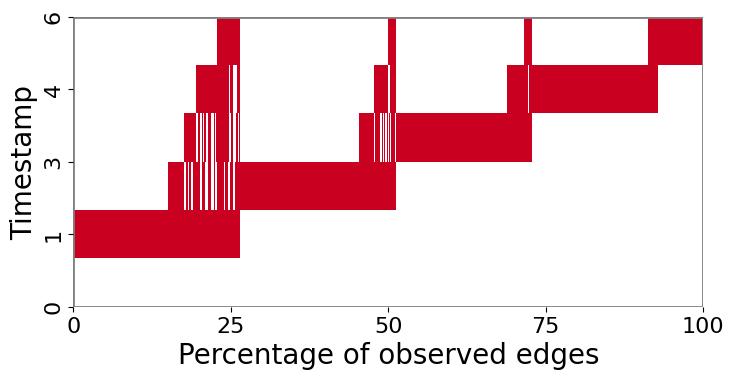

Info: plotting done!
Saved TEA/TET plots.
INFO: Reoccurrence: 0.1299866386715022
INFO: Surprise: 0.5542221252454724
INFO: Novelty: 0.7464612896374252
INFO: Node activity ratio: 0.34225642137206025
Saved largest CC size plot.


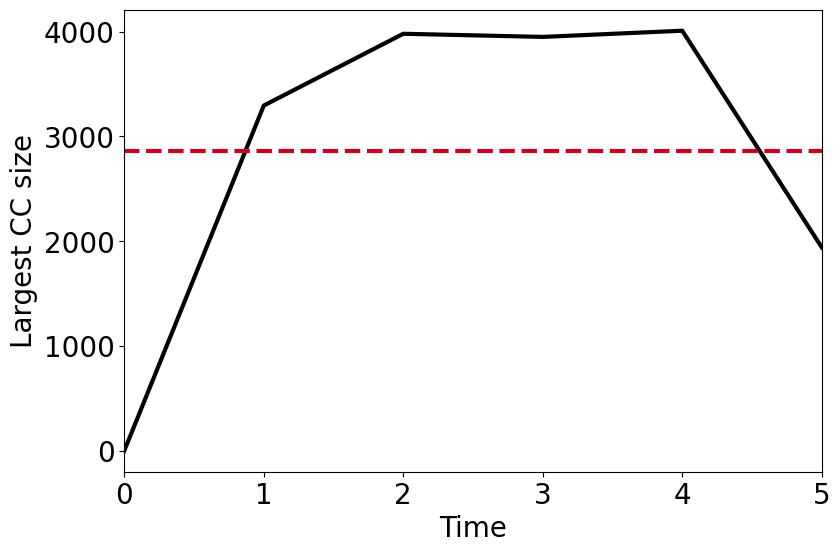

In [12]:
# ──────────────────────────────────────────────────────────────────────────────
# 7) TGX analysis (optional, but great for understanding temporal structure)
#    Produces TEA/TET and time-series plots and temporal stats.
# ──────────────────────────────────────────────────────────────────────────────
if not HAS_TGX:
    raise RuntimeError("TGX not installed. Run `pip install -U py-tgx` and re-run the imports cell above.")

import tgx
from tgx.utils.plotting_utils import plot_for_snapshots

print("TGX:", getattr(tgx, "__version__", "unknown"))

print("[TGX] Loading dataset via tgx.tgb_data ...")
tgx_dataset = tgx.tgb_data(DATASET)  # requires py-tgb to be installed and accessible

# Choose a discretization scale; many datasets look reasonable at 'weekly' or 'monthly'.
time_scale = "weekly"
print("Discretizing with time_scale =", time_scale)

ctdg = tgx.Graph(tgx_dataset)  # continuous-time graph
dtdg, ts_list = ctdg.discretize(time_scale=time_scale, store_unix=True)
print("Discrete snapshots:", len(ts_list))

# Save standard plots into the working directory
tgx.degree_over_time(dtdg, network_name=tgx_dataset.name)
tgx.nodes_over_time(dtdg, network_name=tgx_dataset.name)
tgx.edges_over_time(dtdg, network_name=tgx_dataset.name)
tgx.nodes_and_edges_over_time(dtdg, network_name=tgx_dataset.name)
print("Saved degree/nodes/edges time-series plots.")

# TEA/TET capture novelty vs. recurrence over time—useful for judging baseline difficulty
tgx.TEA(dtdg, network_name=tgx_dataset.name)
tgx.TET(dtdg, network_name=tgx_dataset.name, figsize=(9,5), axis_title_font_size=20, ticks_font_size=16)
print("Saved TEA/TET plots.")

# Temporal stats (parameterized by test_ratio for holdout)
test_ratio = 0.15
reocc = tgx.get_reoccurrence(ctdg, test_ratio=test_ratio)
surpr = tgx.get_surprise(ctdg, test_ratio=test_ratio)
nov   = tgx.get_novelty(dtdg)
act   = tgx.get_avg_node_activity(dtdg)
{
    "reoccurrence": reocc,
    "surprise": surpr,
    "novelty": nov,
    "avg_node_activity": act,
}

# Largest connected component size across snapshots
component_sizes = tgx.size_connected_components(dtdg)
largest_component_sizes = [max(inner) if inner else 0 for inner in component_sizes]
plot_for_snapshots(largest_component_sizes, y_title="Largest CC size",
                   filename=f"./{tgx_dataset.name}_largest_cc")
print("Saved largest CC size plot.")


# Optional:Dataset description

In [13]:
# ──────────────────────────────────────────────────────────────────────────────
# 8) Dataset description & compact profiling (no TGX)
#    Time span, split boundaries, counts, degree stats, inter-event times,
#    edge recurrence (new vs repeated), self-loops/multi-edges, edge features.
# ──────────────────────────────────────────────────────────────────────────────
from datetime import datetime, timezone

src_all = _to_numpy(dataset.src).astype(np.int64)
dst_all = _to_numpy(dataset.dst).astype(np.int64)
ts_all  = _to_numpy(dataset.ts).astype(np.int64)
train_m = _to_numpy(dataset.train_mask).astype(bool)
val_m   = _to_numpy(dataset.val_mask).astype(bool)
test_m  = _to_numpy(dataset.test_mask).astype(bool)

def to_dt(x):
    try:
        return datetime.fromtimestamp(int(x), tz=timezone.utc).isoformat()
    except Exception:
        return str(int(x))

min_ts, max_ts = int(ts_all.min()), int(ts_all.max())
val_start_ts  = int(ts_all[val_m].min()) if val_m.any() else None
test_start_ts = int(ts_all[test_m].min()) if test_m.any() else None

print("=== Time span ===")
print("min_ts:", min_ts, "=>", to_dt(min_ts))
print("max_ts:", max_ts, "=>", to_dt(max_ts))
print("val starts at:", val_start_ts, "=>", (to_dt(val_start_ts) if val_start_ts is not None else None))
print("test starts at:", test_start_ts, "=>", (to_dt(test_start_ts) if test_start_ts is not None else None))

# Basic counts & sparsity
num_nodes = int(dataset.num_nodes)
num_edges = int(dataset.num_edges)
unique_src = int(np.unique(src_all).size)
unique_dst = int(np.unique(dst_all).size)
unique_pairs = int(np.unique(np.stack([src_all, dst_all], axis=1), axis=0).shape[0])

print("=== Sizes ===")
print(f"#nodes: {num_nodes}")
print(f"#edges (total): {num_edges}")
print(f"unique sources: {unique_src}")
print(f"unique destinations: {unique_dst}")
print(f"unique (src,dst) pairs: {unique_pairs}")
possible_pairs = num_nodes * num_nodes
print(f"pair density (unique_pairs / N^2): {unique_pairs / possible_pairs:.6e}")

# Split-wise counts
for name, m in [("train", train_m), ("val", val_m), ("test", test_m)]:
    if not m.any():
        print(f"[{name}] empty split")
        continue
    s = src_all[m]; d = dst_all[m]
    print(f"[{name}] #edges={m.sum()} | unique src={np.unique(s).size} | unique dst={np.unique(d).size}")

# Degree stats
def degree_stats(s, d, N):
    out_deg = np.bincount(s, minlength=N)
    in_deg  = np.bincount(d, minlength=N)
    def summary(x):
        return {
            'min': int(x.min()), 'p50': float(np.percentile(x, 50)), 'p90': float(np.percentile(x, 90)),
            'p99': float(np.percentile(x, 99)), 'max': int(x.max()), 'mean': float(x.mean())
        }
    return summary(out_deg), summary(in_deg)

all_out, all_in = degree_stats(src_all, dst_all, num_nodes)
tr_out, tr_in   = degree_stats(src_all[train_m], dst_all[train_m], num_nodes)
print("=== Degree summary (overall) ===", all_out, "", all_in)
print("=== Degree summary (train)   ===", tr_out,  "", tr_in)

# Top-10 hubs by out-degree
out_deg_all = np.bincount(src_all, minlength=num_nodes)
idx_top = np.argsort(-out_deg_all)[:10]
print("Top-10 nodes by out-degree (node_id: degree):")
print([ (int(i), int(out_deg_all[i])) for i in idx_top ])

# Inter-event time stats (global)
order = np.argsort(ts_all, kind="mergesort")
inter_dt = np.diff(ts_all[order].astype(np.int64))
if inter_dt.size > 0:
    print({
        'inter_event_min': int(inter_dt.min()),
        'p50': float(np.percentile(inter_dt, 50)),
        'p90': float(np.percentile(inter_dt, 90)),
        'p99': float(np.percentile(inter_dt, 99)),
        'inter_event_max': int(inter_dt.max()),
        'mean': float(inter_dt.mean()),
    })
else:
    print("Not enough events to compute inter-event time stats.")

# Edge recurrence: new vs repeated within each split (chronological scan)
def new_vs_repeated_counts(s, d, t, mask):
    idx = np.where(mask)[0]
    if idx.size == 0:
        return 0, 0
    sub = idx[np.argsort(t[idx], kind="mergesort")]
    seen = set()
    earlier = np.where(t < t[sub[0]])[0]
    for i in earlier:
        seen.add((int(s[i]), int(d[i])))
    new_count = 0
    rep_count = 0
    for i in sub:
        key = (int(s[i]), int(d[i]))
        if key in seen:
            rep_count += 1
        else:
            new_count += 1
        seen.add(key)
    return new_count, rep_count

for name, m in [("train", train_m), ("val", val_m), ("test", test_m)]:
    if not m.any():
        continue
    n_new, n_rep = new_vs_repeated_counts(src_all, dst_all, ts_all, m)
    total = int(m.sum())
    print(f"[{name}] new={n_new} ({n_new/total:.2%}) | repeated={n_rep} ({n_rep/total:.2%}) | total={total}")

# Self-loops & multi-edges
self_loops = int((src_all == dst_all).sum())
print(f"self-loops: {self_loops} ({self_loops / num_edges:.2%} of edges)")
pairs = np.stack([src_all, dst_all], axis=1)
_, inv, counts = np.unique(pairs, axis=0, return_inverse=True, return_counts=True)
multi_edges = int((counts[inv] > 1).sum())
print(f"multi-edges (edges on repeated pairs): {multi_edges} ({multi_edges / num_edges:.2%} of edges)")

# Edge features summary (if available)
if getattr(dataset, "edge_feat", None) is not None:
    ef = _to_numpy(dataset.edge_feat)
    print("edge_feat shape:", ef.shape)
    dims = min(ef.shape[1], 8)  # print only first few dims for brevity
    for j in range(dims):
        col = ef[:, j]
        print(f"feat[{j}] -> min={col.min():.4g}, p50={np.percentile(col,50):.4g}, "
              f"p90={np.percentile(col,90):.4g}, max={col.max():.4g}, mean={col.mean():.4g}")
else:
    print("No edge features available on this dataset.")


=== Time span ===
min_ts: 0 => 1970-01-01T00:00:00+00:00
max_ts: 2678373 => 1970-01-31T23:59:33+00:00
val starts at: 1862653 => 1970-01-22T13:24:13+00:00
test starts at: 2218300 => 1970-01-26T16:11:40+00:00
=== Sizes ===
#nodes: 9227
#edges (total): 157474
unique sources: 8227
unique destinations: 1000
unique (src,dst) pairs: 18257
pair density (unique_pairs / N^2): 2.144413e-04
[train] #edges=110232 | unique src=6523 | unique dst=952
[val] #edges=23621 | unique src=2470 | unique dst=786
[test] #edges=23621 | unique src=2776 | unique dst=788
=== Degree summary (overall) === {'min': 0, 'p50': 2.0, 'p90': 37.0, 'p99': 255.95999999999913, 'max': 1603, 'mean': 17.066652216321664}  {'min': 0, 'p50': 0.0, 'p90': 88.0, 'p99': 260.7399999999998, 'max': 1937, 'mean': 17.066652216321664}
=== Degree summary (train)   === {'min': 0, 'p50': 1.0, 'p90': 24.0, 'p99': 177.0, 'max': 1131, 'mean': 11.946678226942668}  {'min': 0, 'p50': 0.0, 'p90': 12.0, 'p99': 197.0, 'max': 1332, 'mean': 11.946678226942

# Optional: Export for Gephi

In [14]:
# ──────────────────────────────────────────────────────────────────────────────
# 9) Export edgelist/nodes for Gephi — adaptive time
#    Uses UNIX timestamps if epoch-like, else falls back to index-based time.
# ──────────────────────────────────────────────────────────────────────────────
import pandas as pd
from IPython.display import display

EXPORT_SPLIT  = "all"    # "all", "train", "val", or "test"
TIME_MODE     = "auto"   # "auto" | "index" | "index_start_end" | "unix" | "iso_utc"
AUTO_IF_UNIX  = "unix"   # with TIME_MODE="auto": choose "unix" (raw sec) vs "iso_utc" (readable)
OUT_DIR = Path("exports"); OUT_DIR.mkdir(parents=True, exist_ok=True)

def _mask_for_split(ds, split: str):
    if split == "train":
        return _to_numpy(ds.train_mask).astype(bool)
    if split == "val":
        return _to_numpy(ds.val_mask).astype(bool)
    if split == "test":
        return _to_numpy(ds.test_mask).astype(bool)
    return np.ones(int(ds.num_edges), dtype=bool)  # "all"

def _detect_epoch_and_seconds(ts_arr: np.ndarray) -> Tuple[bool, np.ndarray]:
    ts_arr = np.asarray(ts_arr, dtype=np.int64)
    if ts_arr.size == 0:
        return False, ts_arr.astype(float)
    tmin = int(np.nanmin(ts_arr))
    # Guess unit by magnitude
    if tmin >= 1_000_000_000_000_000_000:   # ns
        secs = ts_arr / 1_000_000_000
    elif tmin >= 1_000_000_000_000_000:     # μs
        secs = ts_arr / 1_000_000
    elif tmin >= 1_000_000_000_000:         # ms
        secs = ts_arr / 1_000
    else:                                   # seconds or small relative ints
        secs = ts_arr.astype(float)
    is_epoch = (secs.min() >= 1_000_000_000.0) and (secs.max() < 10_000_000_000.0)
    return bool(is_epoch), secs

def _format_time_auto(ts_idx_subset: np.ndarray, ts_all: np.ndarray, prefer: str = "unix"):
    is_epoch, secs_all = _detect_epoch_and_seconds(ts_all)
    secs_sub = secs_all[ts_idx_subset]
    if is_epoch:
        if prefer == "unix":
            return pd.Series(secs_sub.astype(np.int64))
        dt = pd.to_datetime(secs_sub, unit="s", utc=True)
        return pd.Series(dt.tz_convert(None).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return pd.Series(np.arange(len(ts_idx_subset), dtype=np.int64))

def export_edgelist_for_gephi(ds, path: str, split: str = "all",
                              time_mode: str = "auto", auto_if_unix: str = "unix"):
    src = _to_numpy(ds.src).astype(np.int64)
    dst = _to_numpy(ds.dst).astype(np.int64)
    ts  = _to_numpy(ds.ts).astype(np.int64)
    m = _mask_for_split(ds, split)
    idx = np.where(m)[0]  # preserve dataset order (chronological)
    df = pd.DataFrame({"Source": src[idx], "Target": dst[idx], "Type": ["Directed"] * len(idx)})

    if time_mode == "auto":
        df["Time"] = _format_time_auto(idx, ts, prefer=auto_if_unix)
    elif time_mode == "index":
        df["Time"] = np.arange(len(idx), dtype=np.int64)
    elif time_mode == "index_start_end":
        df["Start"] = np.arange(len(idx), dtype=np.int64); df["End"] = ""
    elif time_mode == "unix":
        df["Time"] = ts[idx]
    elif time_mode == "iso_utc":
        is_epoch, secs_all = _detect_epoch_and_seconds(ts)
        if is_epoch:
            dt = pd.to_datetime(secs_all[idx], unit="s", utc=True)
            df["Time"] = dt.tz_convert(None).strftime("%Y-%m-%d %H:%M:%S")
        else:
            df["Time"] = np.arange(len(idx), dtype=np.int64)
    else:
        raise ValueError("TIME_MODE must be one of: 'auto', 'index', 'index_start_end', 'unix', 'iso_utc'")

    df.to_csv(path, index=False)
    return df.head()

def export_nodes_for_gephi(ds, path: str):
    n = int(ds.num_nodes)
    nodes = pd.DataFrame({"Id": np.arange(n, dtype=np.int64), "Label": np.arange(n, dtype=np.int64)})
    nodes.to_csv(path, index=False)
    return nodes.head()

edges_path = OUT_DIR / f"{DATASET}_{EXPORT_SPLIT}_edges_gephi.csv"
nodes_path = OUT_DIR / f"{DATASET}_nodes_gephi.csv"

print(f"Writing: {edges_path}")
edges_preview = export_edgelist_for_gephi(dataset, str(edges_path),
                                          split=EXPORT_SPLIT, time_mode=TIME_MODE, auto_if_unix=AUTO_IF_UNIX)
print(f"Writing: {nodes_path}")
nodes_preview = export_nodes_for_gephi(dataset, str(nodes_path))

print("Edge preview (first 5 rows):")
display(edges_preview)
print("Node preview (first 5 rows):")
display(nodes_preview)

# Gephi quick import:
# 1) File → Import Spreadsheet → nodes CSV as Nodes.
# 2) File → Import Spreadsheet → edges CSV as Edges.
# 3) Separator: Comma • Graph type: Directed • Time column: Time (or Start/End).


Writing: exports/tgbl-wiki_all_edges_gephi.csv
Writing: exports/tgbl-wiki_nodes_gephi.csv
Edge preview (first 5 rows):


,Source,Target,Type,Time
0,0,8227,Directed,0
1,1,8228,Directed,1
2,1,8228,Directed,2
3,2,8229,Directed,3
4,1,8228,Directed,4


Node preview (first 5 rows):


,Id,Label
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
